## VAE CeleA faces

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.stats import norm
from tensorflow.keras import callbacks  # 包含一些回调函数,观察训练过程中的一些信息 但不同于visualization模块
from tensorflow.keras import layers, losses, metrics, models, optimizers, utils
from utils import display, sample_batch
from vae_utils import add_vector_to_images, get_vector_from_label, morph_faces

## 0, Parameters

In [168]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
CHANNELS = 3
NUM_FEATURES = 64  # ???
Z_DIM = 10 #200
LEARNING_RATE = 0.0005
EPOCHS = 1
BETA = 2000  # ??
LOAD_MODEL = False  # ???

## 1, Prepare the data

In [169]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/Users/leiou/Documents/foster/GDL2E/data/celeba-dataset/img_align_celebb",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 46232 files belonging to 1 classes.


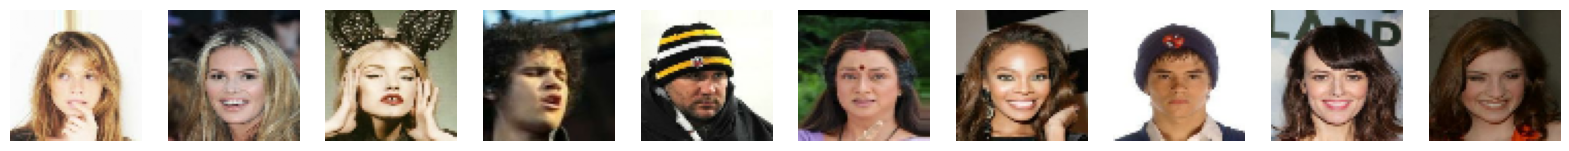

In [170]:
# preprocess data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))
train_sample = sample_batch(train)
display(train_sample, cmap=None)

## 2, Build VAE

In [171]:
# 对于隐空间的batch个样本,每个样本的维度数量 z_mean[1],
# 从每个样本在每个维度的两个值z_mean z_log_var利用标准正态分布epsilon取样得到标量z
# 一共得到batch个 z
# 返回值shape=(batch,1)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs  # latent spaces
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))  # 128x 200
        # print(epsilon.shape)
        # epsilon在反向传播时作为常数参数,而不是作为权重参数.
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # 128x 200

In [172]:
## 考虑epsilon如何反向传播

In [173]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"  # 64x64x3
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)  # 32x32x NUM_FEATURES=64

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)  # 16x16x64
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)  # 8x8x64
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)  # 4x4x64
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)  # 2x2x64

shape_before_flattening = K.int_shape(x)[1:]  # (2,2,64)for decoder

x = layers.Flatten()(x)  # 2x2x64=256
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)  # Z_DIM=200
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
# print(z.shape)# 128x200
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_110 (B  (None, 32, 32, 64)           256       ['conv2d_50[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 leaky_re_lu_110 (LeakyReLU  (None, 32, 32, 64)           0         ['batch_normalization_11

In [174]:
# decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")  # 仅z传送下去
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# 200--->np.prod(shape_before_flattening)==256
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)  # 256-->2x2x64


x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # 4x4x64
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # 8x8*64
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # 16*16*64
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # 32x32x64
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)  # 64x64x64
x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"  # rgb三通道
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2816      
                                                                 
 batch_normalization_115 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 leaky_re_lu_115 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 reshape_10 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_60 (Conv2  (None, 4, 4, 64)          369

In [185]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):   #前向传播
        # call the model on a particular input
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)  # 调用call()前向传播
            mse = BETA * losses.mean_squared_error(data, reconstruction)
            # mse得到降一维的张量,即最后一维进行mse运算, 超参数BETA 调整原图vs重构的损失的权重
            reconstruction_loss = tf.reduce_mean(mse)  # 未指定axis,即axis=None,则结果是标量
            # n个样本, 每个样本m个隐空间维度,
            # 对于每个样本,加总各个维度与标准正态分布的kl散度,结果shape==(n,)
            kl_loss = tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1
            )
            # 对上面的向量求平均值,得到一个标量
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {   #训练过程中动态显示以下内容
            "LOSS:": self.total_loss_tracker.result(),
            "reconstruction_lLOSS:": self.reconstruction_loss_tracker.result(),
            "kl_LOSS:": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):  # step run during validation
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_absolute_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss
        return {
            "total loss": total_loss,
            "reconstruction loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def get_config(self):
        config = {
            'encoder': self.encoder,
            'decoder': self.decoder
        }
        base_config = super(VAE, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

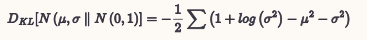

## 3,train VAE

In [186]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.legacy.Adam(learning_rate=LEARNING_RATE))
# create a model checkpoint
model_checkpoint_callback=callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0
)
tensorboard_callback=callbacks.TensorBoard(log_dir="./logs")

In [187]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [188]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [189]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=2, latent_dim=Z_DIM),  #10
    ],
)

 25/362 [=>............................] - ETA: 2:08 - LOSS:: 76.2347 - reconstruction_lLOSS:: 63.1743 - kl_LOSS:: 13.0604

KeyboardInterrupt: 

In [180]:
# save the final model
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


## R


4/4 [==============================] - 0s 32ms/step
Example real faces


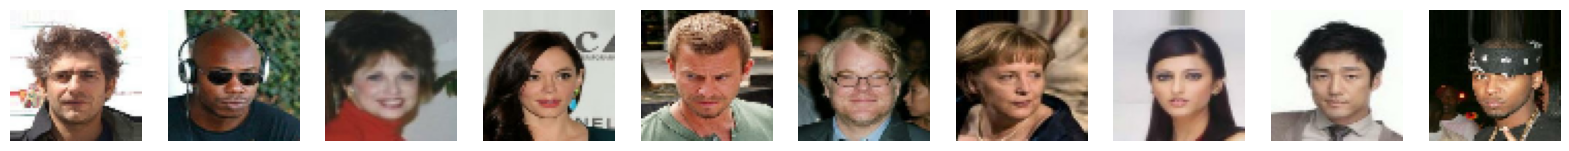

Reconstructions


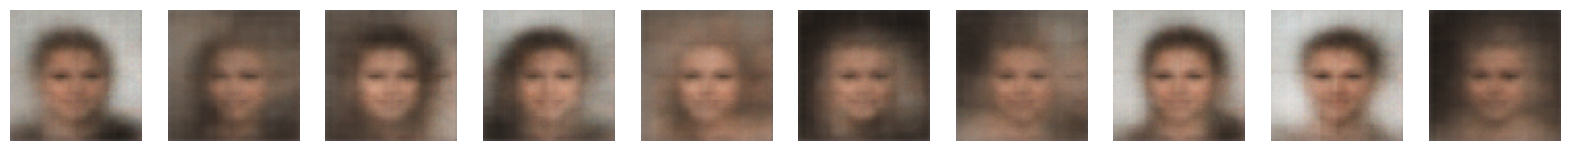

In [181]:
#selct a subset of test set
batches_to_predict=1
example_imgs=np.array(list(train.take(batches_to_predict).get_single_element()))
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_imgs)
print("Example real faces")
display(example_imgs)
print("Reconstructions")
display(reconstructions)

In [182]:
# 练习沿axis轴计算
import tensorflow as tf

x = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])  # x.shape==(2,3)
result = tf.reduce_mean(x)  # 不指定轴,求全体元素的总平均数
print(result.numpy())  # 3.5
result = tf.reduce_mean(x, axis=0)  # shape==(3,)
print(result.numpy())  # [2.5 3.5  4.5]
result = tf.reduce_mean(x, axis=1)
print(result.numpy())  # [2 5]

3.5
[2.5 3.5 4.5]
[2. 5.]


In [183]:
x = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y = tf.constant([[3.0, 2.0, 1.0], [4.0, 5.0, 6.0]])
losses.mean_squared_error(x, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.6666667, 0.       ], dtype=float32)>

In [184]:
x = tf.constant(
    [[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], [[4.0, 5.0, 6.0], [4.0, 5.0, 6.0]]]
)
y = tf.constant(
    [[[1.1, 2.1, 3.1], [4.1, 5.1, 6.1]], [[4.0, 5.0, 6.0], [4.0, 5.0, 6.0]]]
)
print(x.shape)
losses.mean_squared_error(x, y)

(2, 2, 3)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.00999999, 0.00999998],
       [0.        , 0.        ]], dtype=float32)>